In [4]:
import cv2
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import math

In [10]:
def count_files(directory):
    if not os.path.isdir(directory):
        print(f"{directory} is not a valid directory.")
        return

    return len(os.listdir(directory))

def count_specific_files(directory, extensions):
    if not os.path.isdir(directory):
        print(f"{directory} is not a valid directory.")
        return

    file_count = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(tuple(extensions)):
                file_count += 1

    return file_count

In [8]:
datasetFolder = "./dataset/pavement_dataset"
trainData = f"{datasetFolder}/train"
validData = f"{datasetFolder}/valid"
testData = f"{datasetFolder}/test"
megaData = f"{datasetFolder}/mega"

class_names = ['alligator_crack', 'block_crack', 'longitudinal_crack', 'pothole', 'sealed_longitudinal_crack', 'sealed_transverse_crack', 'transverse_crack']

image_folder = f"{validData}/images"
label_folder = f"{validData}/labels"

In [16]:
count_files(megaData)
extensions = ('.jpg', '.txt')
count_specific_files(megaData, extensions)

16264

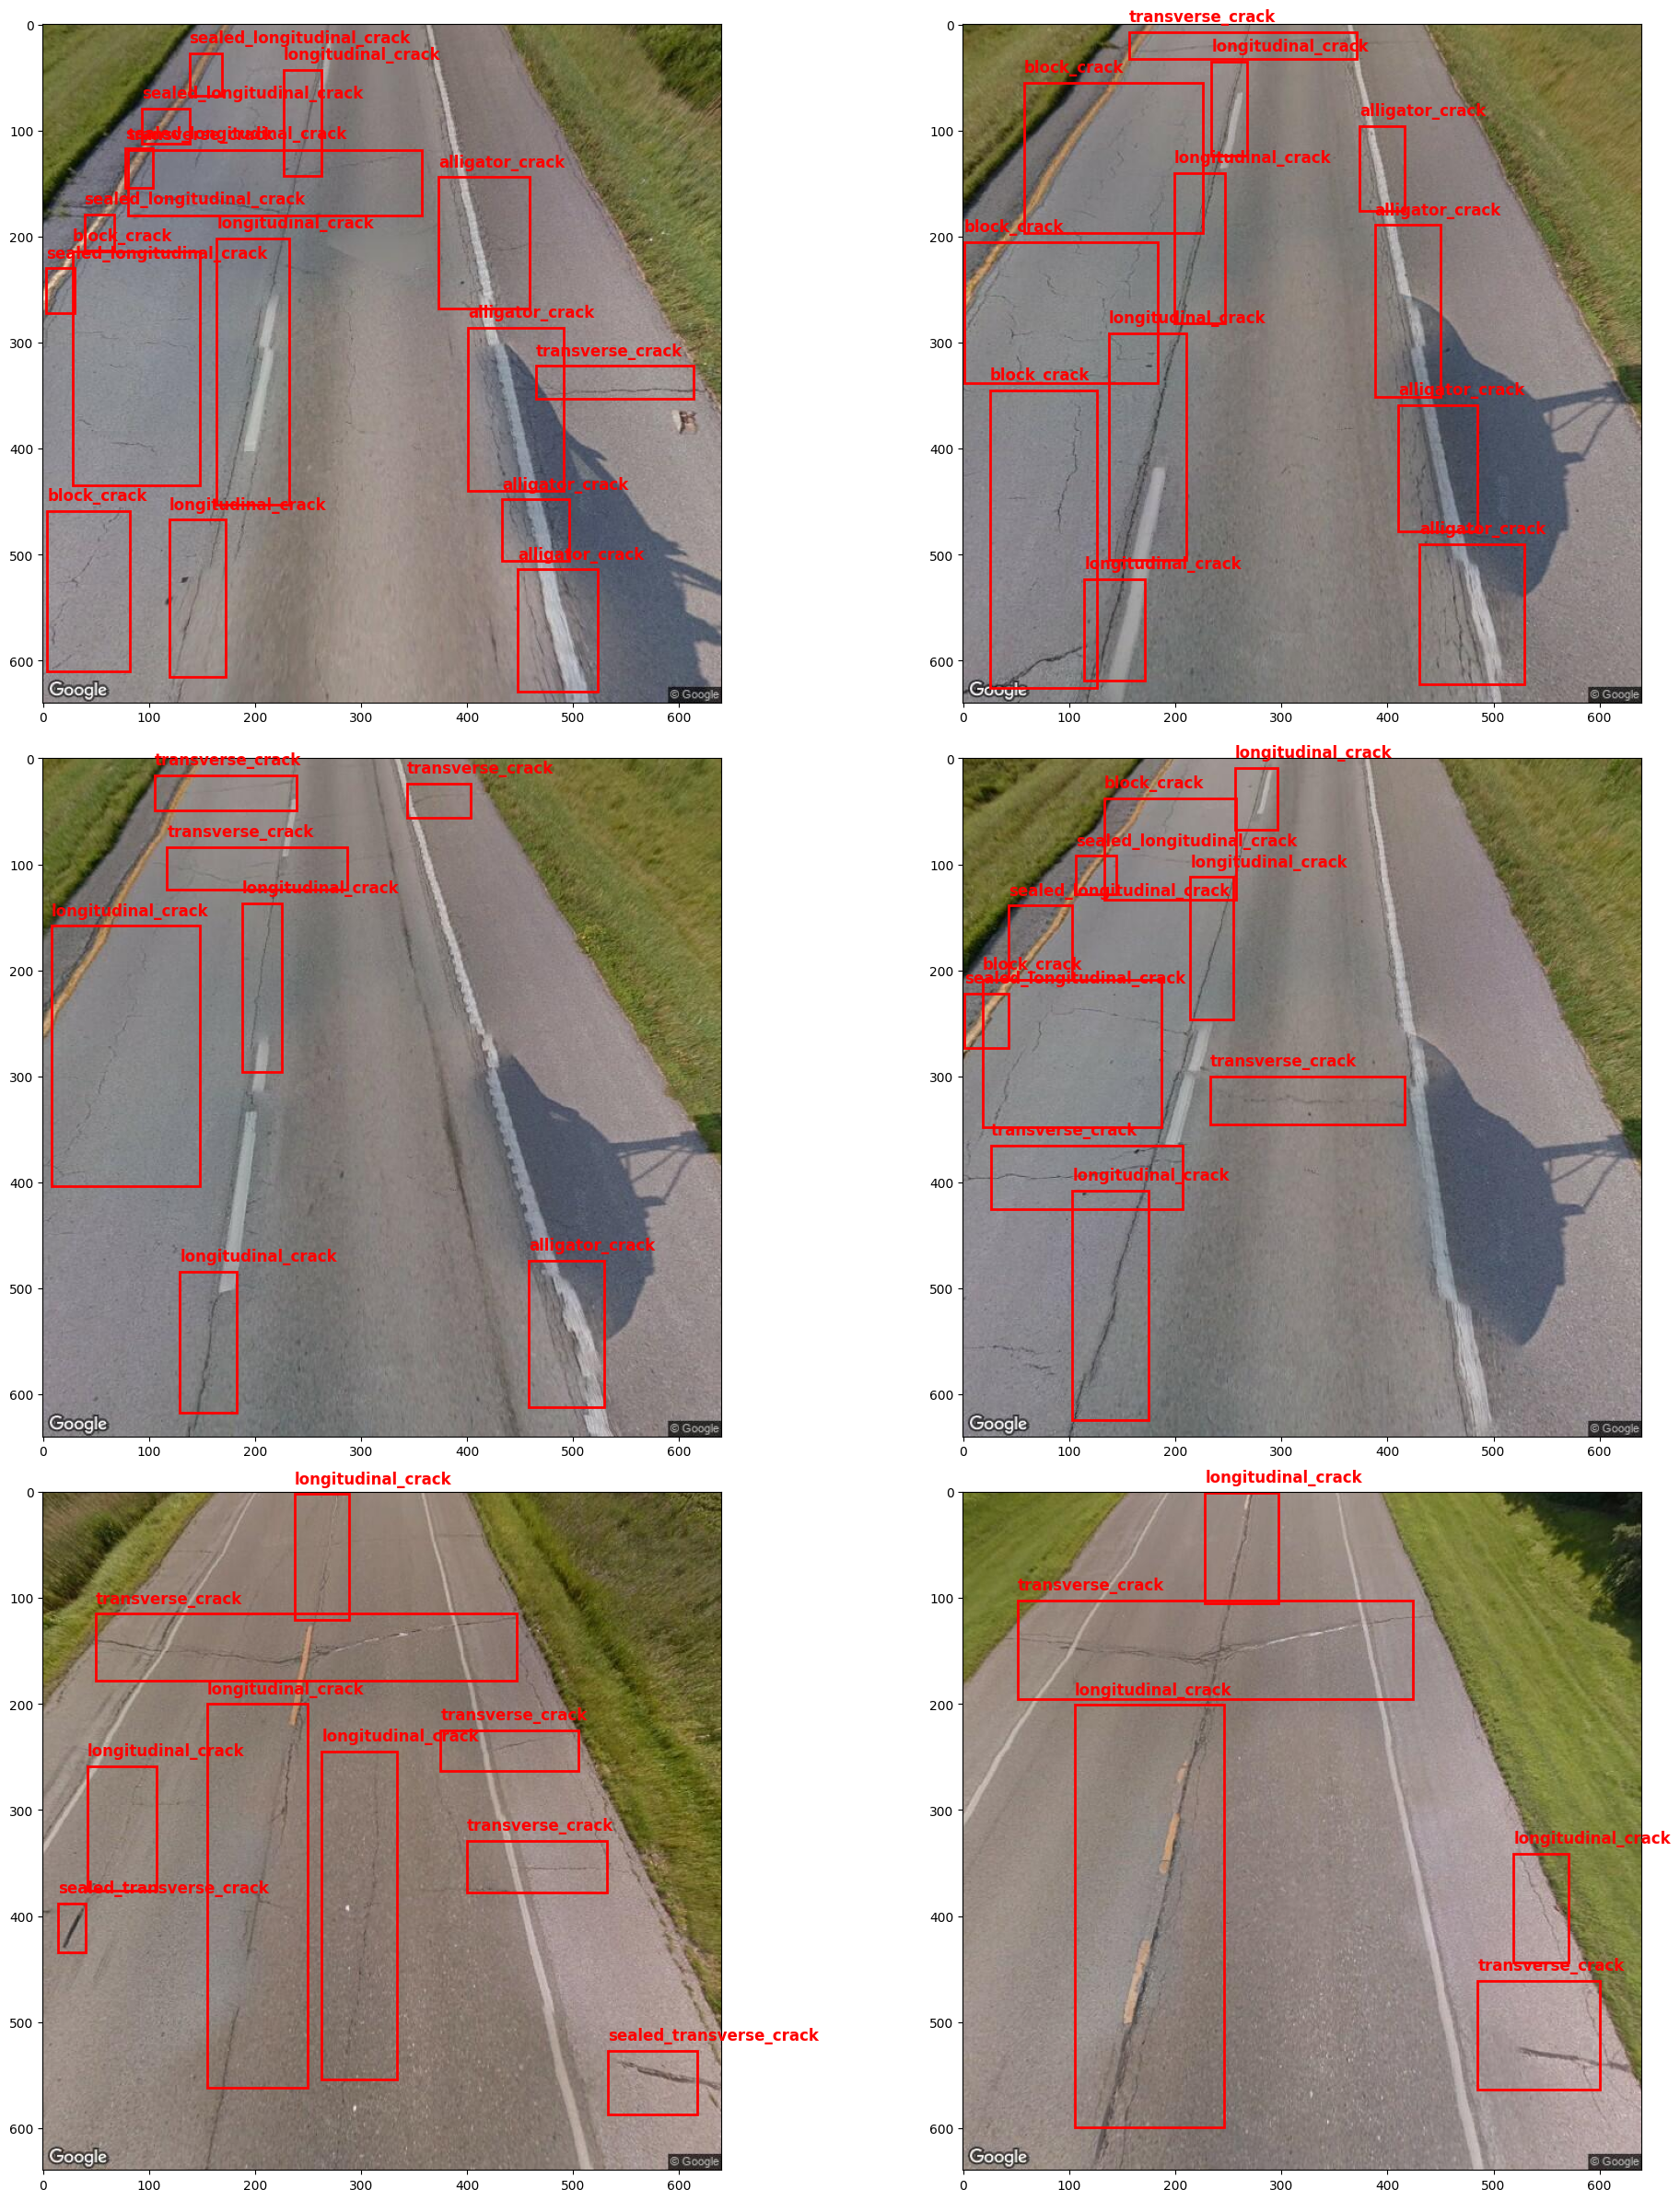

In [5]:
def plot_random_images_with_bbox(image_folder, label_folder, num_images=4):
    image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]
    label_paths = [os.path.join(label_folder, filename) for filename in os.listdir(label_folder)]
    
    # Randomly select images
    random_image_paths = random.sample(image_paths, num_images)
    random_label_paths = [os.path.join(label_folder, os.path.basename(image_path).replace('.jpg', '.txt')) for image_path in random_image_paths]

    num_rows = math.ceil(num_images / 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(20, 8 * num_rows))

    for i, (image_path, label_path) in enumerate(zip(random_image_paths, random_label_paths)):
        row_index = i // 2
        col_index = i % 2

        # Read image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read corresponding label
        with open(label_path, 'r') as file:
            labels = file.readlines()

        # Plot image
        axes[row_index, col_index].imshow(image)

        # Plot bounding boxes
        for label in labels:
            class_index, x_center, y_center, width, height = map(float, label.split())
            image_height, image_width, _ = image.shape
            x_min = int((x_center - width / 2) * image_width)
            y_min = int((y_center - height / 2) * image_height)
            x_max = int((x_center + width / 2) * image_width)
            y_max = int((y_center + height / 2) * image_height)
            axes[row_index, col_index].add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='r', linewidth=2))
            # Plot class index
            class_name = class_names[int(class_index)]
            axes[row_index, col_index].text(x_min, y_min - 10, f'{class_name}', color='red', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

plot_random_images_with_bbox(image_folder, label_folder, num_images=6)

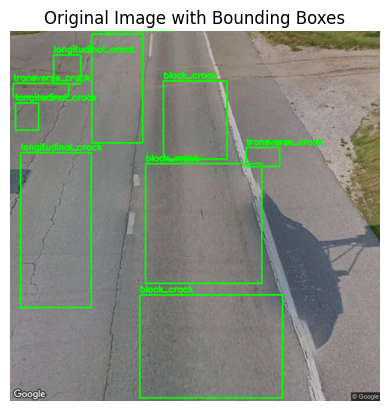

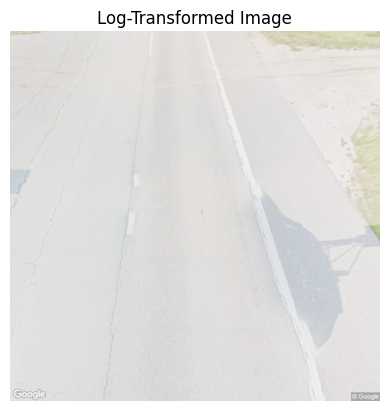

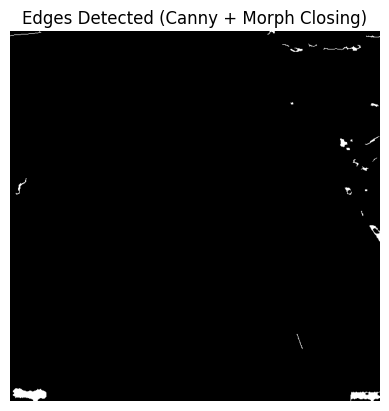

In [6]:
def plot_bboxes(image, labels, class_names):
    for label in labels:
        class_index, x_center, y_center, width, height = map(float, label.split())
        image_height, image_width, _ = image.shape
        x_min = int((x_center - width / 2) * image_width)
        y_min = int((y_center - height / 2) * image_height)
        x_max = int((x_center + width / 2) * image_width)
        y_max = int((y_center + height / 2) * image_height)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        class_name = class_names[int(class_index)]
        cv2.putText(image, class_name, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

# Function to crop the image using bounding boxes
def crop_image(image, labels):
    cropped_images = []
    for label in labels:
        class_index, x_center, y_center, width, height = map(float, label.split())
        image_height, image_width, _ = image.shape
        x_min = int((x_center - width / 2) * image_width)
        y_min = int((y_center - height / 2) * image_height)
        x_max = int((x_center + width / 2) * image_width)
        y_max = int((y_center + height / 2) * image_height)
        cropped_images.append(image[y_min:y_max, x_min:x_max])
    return cropped_images

# Read one random image and its corresponding label
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]
label_paths = [os.path.join(label_folder, filename) for filename in os.listdir(label_folder)]
random_index = random.randint(0, len(image_paths) - 1)
image_path = image_paths[random_index]
label_path = label_paths[random_index]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
with open(label_path, 'r') as file:
    labels = file.readlines()

# Plot bounding boxes on the original image
image_with_bboxes = plot_bboxes(image.copy(), labels, class_names=class_names)

# Crop the image using bounding boxes
cropped_images = crop_image(image, labels)

# Apply logarithmic transformation to the image
log_transformed_image = np.log1p(image.astype(np.float32)) * (255 / np.log1p(255)).astype(np.float32)
log_transformed_image = log_transformed_image.astype(np.uint8)

# Apply Canny edge detection to the log-transformed image
edges = cv2.Canny(log_transformed_image, 100, 200)

# Perform morphological closing on the detected edges
edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

# Plot the original image with bounding boxes
plt.imshow(image_with_bboxes)
plt.title('Original Image with Bounding Boxes')
plt.axis('off')
plt.show()

# Plot the log-transformed image
plt.imshow(log_transformed_image, cmap='gray')
plt.title('Log-Transformed Image')
plt.axis('off')
plt.show()

# Plot the edges detected after Canny edge detection
plt.imshow(edges_closed, cmap='gray')
plt.title('Edges Detected (Canny + Morph Closing)')
plt.axis('off')
plt.show()